In [ ]:
################################################################################
################ Carlos Alberto Vidrios Serrano ################################
################################################################################

!uv pip install -q --system numba-cuda==0.4.0
!pip install pynvjitlink-cu12

import numpy as np
from numba import cuda
import time
import os
from numba import config
import numba
config.CUDA_ENABLE_PYNVJITLINK=1

In [ ]:
import numpy as np
from numba import cuda
import math
import time

@cuda.jit
def vector_add_kernel(a, b, c):
  """
  Each thread computes one element: c[i] = a[i] + b[i]
  """
  #compute global thread index
  idx = cuda.grid(1)

  #Boundary check
  if idx < c.size:
    c[idx] = a[idx] + b[idx]


def main():
  N_large = 10_000_000
  a = np.random.randn(N_large).astype(np.float32)
  b = np.random.randn(N_large).astype(np.float32)
  c = np.zeros(N_large, dtype=np.float32) # Fixed: Changed np.zeros_like(N_large, ...) to np.zeros(N_large, ...)

  d_a = cuda.to_device(a)
  d_b = cuda.to_device(b)
  d_c = cuda.to_device(c)

  threads_per_block = 256
  brocks_per_grid = math.ceil(N_large / threads_per_block)

  #Warmup
  vector_add_kernel[brocks_per_grid, threads_per_block](d_a, d_b, d_c)
  cuda.synchronize()

  #GPU timing
  start = time.time()
  vector_add_kernel[brocks_per_grid, threads_per_block](d_a, d_b, d_c)
  cuda.synchronize()
  gpu_time = (time.time() - start) * 1000

  result = d_c.copy_to_host()

  #CPU timing
  cpu_start = time.time()
  expected = a + b # Fixed: Changed 'bin' to 'b'
  cpu_time = (time.time() - cpu_start)*1000

  print(f"GPU kernel time: {gpu_time:.3f} ms")
  print(f"CPU Numpy time: {cpu_time:.3f} ms")
  print(f"Speedup: {cpu_time/gpu_time:.3f}x")
  print("Correct:", np.allclose(result, expected))

if __name__ == "__main__":
  main()

GPU kernel time: 0.554 ms
CPU Numpy time: 15.240 ms
Speedup: 27.493x
Correct: True


In [ ]:
import numpy as np
from numba import cuda
import math
import time

@cuda.jit
def dummy_compute_kernel(a, b, c):
  """
  Each thread computes one element: c[i] = sqrt(a[i]^2 + b[i]^2)
  """
  #compute global thread index
  idx = cuda.grid(1)

  #Boundary check
  if idx < c.size:
    c[idx] = math.sqrt(a[idx]**2 + b[idx]**2)


def main():
  N_large = 10_000_000
  a = np.random.randn(N_large).astype(np.float32)
  b = np.random.randn(N_large).astype(np.float32)
  c = np.zeros(N_large, dtype=np.float32) # Fixed: Changed np.zeros_like(N_large, ...) to np.zeros(N_large, ...)

  d_a = cuda.to_device(a)
  d_b = cuda.to_device(b)
  d_c = cuda.to_device(c)

  threads_per_block = 256
  brocks_per_grid = math.ceil(N_large / threads_per_block)

  #Warmup
  dummy_compute_kernel[brocks_per_grid, threads_per_block](d_a, d_b, d_c)
  cuda.synchronize()

  #GPU timing
  start = time.time()
  dummy_compute_kernel[brocks_per_grid, threads_per_block](d_a, d_b, d_c)
  cuda.synchronize()
  gpu_time = (time.time() - start) * 1000

  result = d_c.copy_to_host()

  #CPU timing
  cpu_start = time.time()
  expected = np.sqrt(a**2 + b**2) # Fixed: Changed 'bin' to 'b'
  cpu_time = (time.time() - cpu_start)*1000

  print(f"GPU kernel time: {gpu_time:.3f} ms")
  print(f"CPU Numpy time: {cpu_time:.3f} ms")
  print(f"Speedup: {cpu_time/gpu_time:.3f}x")
  print("Correct:", np.allclose(result, expected))

if __name__ == "__main__":
  main()

GPU kernel time: 0.569 ms
CPU Numpy time: 43.597 ms
Speedup: 76.574x
Correct: True


In [ ]:
import numpy as np
from numba import cuda
import math
import time

@cuda.jit
def matrix_scale_kernel(mat, scalar, out):
  """
  Scalar every element: out[row, col] = mat[row, col] * scalar
  """
  #compute global thread index
  row, col = cuda.grid(2)

  #Boundary check
  if row < out.shape[0] and col < out.shape[1]:
    out[row, col] = mat[row, col] * scalar

def main():
  rows_large, cols_large = 4096, 4096
  mat = np.random.randn(rows_large, cols_large).astype(np.float32)
  out = np.zeros_like(mat)
  scalar = 2.5
  d_mat = cuda.to_device(mat)
  d_out = cuda.to_device(out)

  threads_per_block = (16, 16)
  blocks_per_grid_x = math.ceil(rows_large / threads_per_block[0])
  blocks_per_grid_y = math.ceil(cols_large / threads_per_block[1])
  blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

  #Warmup
  matrix_scale_kernel[blocks_per_grid, threads_per_block](d_mat, scalar, d_out)
  cuda.synchronize()

  #GPU timing
  start = time.time()
  matrix_scale_kernel[blocks_per_grid, threads_per_block](d_mat, scalar, d_out)
  cuda.synchronize()
  gpu_time = (time.time() - start) * 1000

  result = d_out.copy_to_host()

  #CPU timing
  cpu_start = time.time()
  expected = mat*scalar
  cpu_time = (time.time() - cpu_start)*1000

  print(f"GPU kernel time: {gpu_time:.3f} ms")
  print(f"CPU Numpy time: {cpu_time:.3f} ms")
  print(f"Speedup: {cpu_time/gpu_time:.3f}x")
  print("Correct:", np.allclose(result, expected))

if __name__ == "__main__":
  main()

GPU kernel time: 1.821 ms
CPU Numpy time: 21.793 ms
Speedup: 11.967x
Correct: True


In [ ]:
#Matrix multiplications
import numpy as np
from numba import cuda
import math
import time

@cuda.jit
def matmul_naive_kernel(A, B, C):
  """
  Naive matrix multiply: C= A@B
  Each thread computes one element of C
  All reads from A and B go to global memory (slow)
  A: (M, K)
  B: (K, N)
  C: (M, N)
  """
  row, col = cuda.grid(2)

  M, K = A.shape
  K2, N = B.shape

  #Boundary check
  if row < M and col < N:
    total = 0.0
    for k in range(K):
      total += A[row, k] * B[k, col]
    C[row, col] = total

def main():
  M, K, N = 1000, 1000, 1000
  A = np.random.randn(M, K).astype(np.float32)
  B = np.random.randn(K, N).astype(np.float32)
  C = np.zeros((M, N), dtype=np.float32)

  threads_per_block = (32, 32)
  d_A = cuda.to_device(A)
  d_B = cuda.to_device(B)
  d_C = cuda.to_device(C)

  # Correct calculation for blocks_per_grid to ensure integer values
  blocks_per_grid_x = math.ceil(M / threads_per_block[0])
  blocks_per_grid_y = math.ceil(N / threads_per_block[1])
  blocks_per_grid = (int(blocks_per_grid_x), int(blocks_per_grid_y))

  #Warmup
  matmul_naive_kernel[blocks_per_grid, threads_per_block](d_A, d_B, d_C)
  cuda.synchronize()

  #GPU timing
  start = time.time()
  matmul_naive_kernel[blocks_per_grid, threads_per_block](d_A, d_B, d_C)
  cuda.synchronize()
  gpu_time = (time.time() - start) * 1000

  c_gpu = d_C.copy_to_host()

  #CPU timing
  cpu_start = time.time()
  expected = A@B
  cpu_time = (time.time() - cpu_start)*1000

  print(f"GPU kernel time: {gpu_time:.3f} ms")
  print(f"CPU Numpy time: {cpu_time:.3f} ms")
  print(f"Speedup: {cpu_time/gpu_time:.3f}x")
  print("Correct: {np.allclose(c_gpu, expected, atol=1e-3)}")

if __name__ == "__main__":
  main()

GPU kernel time: 52.185 ms
CPU Numpy time: 30.541 ms
Speedup: 0.585x
Correct: {np.allclose(c_gpu, expected, atol=1e-3)}


In [ ]:
!pip install opencv-python

Image: 3840x2160 (8,294,400 pixels)
Grid: (240, 135) blocks x (32, 32) threads

Results
GPU kernel time: 24.902 ms
CPU Numpy time: 97.660 ms
Speedup: 3.922x
Correct: False


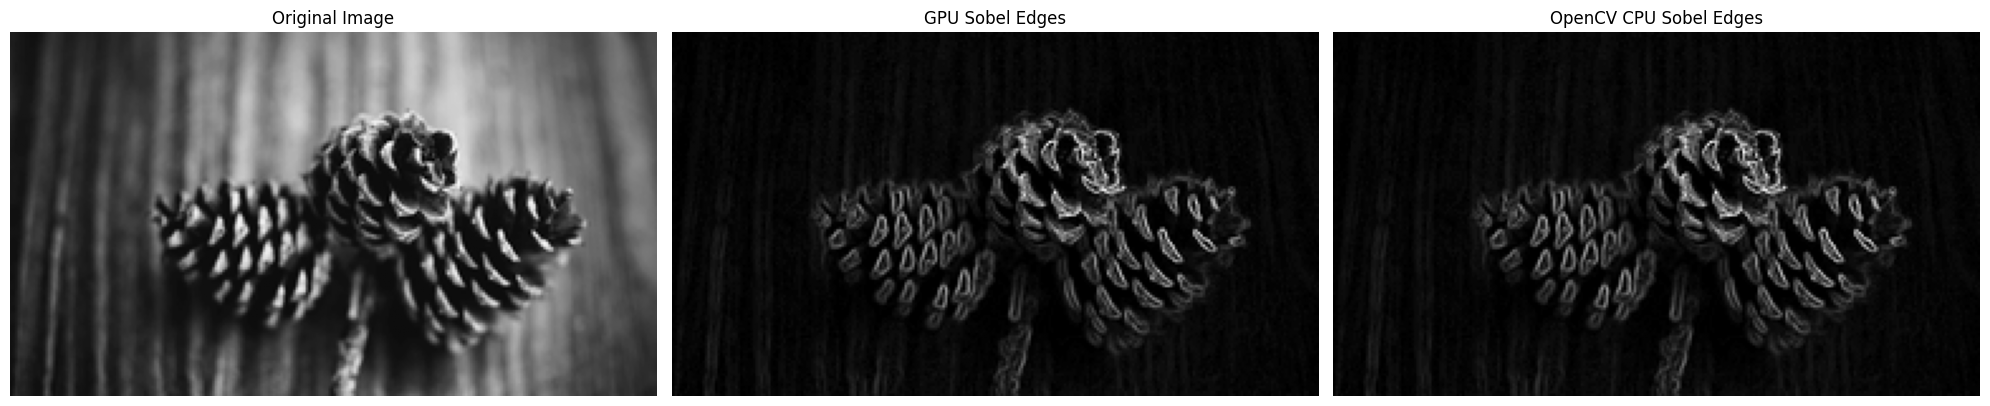

In [ ]:
#Aplicacion con filtro de sobel
import numpy as np
import numba.cuda as cuda
import time
import urllib.request
from PIL import Image
from matplotlib import pyplot as plt
import cv2

@cuda.jit
def sobel_kernel(img, out):
  """
  Apply sobel edge detection - each thread processes one pixel
  """
  row, col = cuda.grid(2)
  H, W = img.shape

  #Boundary check
  if 0 < row < H-1 and 0 < col < W-1:
    #Horizontal gradient (Gx)
    gx = (-img[row-1, col-1] + img[row-1, col+1]+
          -2*img[row, col-1] + 2*img[row,col+1]+
          -img[row+1, col-1] + img[row+1, col+1])

    #vertical gradient (Gy)
    gy = (-img[row-1, col-1] - 2*img[row-1, col] - img[row-1, col+1]+
          img[row+1, col-1] + 2*img[row+1, col] + img[row+1, col+1])

    #edge magnitude
    out[row, col] = (gx**2 + gy**2)**0.5


def sobel_opencv(img):
  gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
  gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
  return np.sqrt(gx**2 + gy**2)


#load 4K image from internet
urllib.request.urlretrieve("https://picsum.photos/3840/2160", "image.jpg")
img = Image.open("image.jpg").convert("L")
img = np.asarray(img, dtype=np.float32)

H, W = img.shape
print(f"Image: {W}x{H} ({W*H:,} pixels)")

d_img = cuda.to_device(img)
d_out = cuda.to_device(np.zeros_like(img))

threads = (32, 32)
blocks = (W + 15) // 16, (H + 15) // 16

print(f"Grid: {blocks} blocks x {threads} threads")

#Warmup
sobel_kernel[blocks, threads](d_img, d_out)
cuda.synchronize()

#GPU timing
start = time.time()
sobel_kernel[blocks, threads](d_img, d_out)
cuda.synchronize()
gpu_time = (time.time() - start) * 1000

out_gpu = d_out.copy_to_host()

#CPU timing
cpu_start = time.time()
out_cpu = sobel_opencv(img)
cpu_time = (time.time() - cpu_start)*1000

#results
print("\n" + "="*50)
print("Results")
print("="*50)
print(f"GPU kernel time: {gpu_time:.3f} ms")
print(f"CPU Numpy time: {cpu_time:.3f} ms")
print(f"Speedup: {cpu_time/gpu_time:.3f}x")
print(f"Correct: {np.allclose(out_gpu, out_cpu, atol=1e-3)}")

# Resize for display
H, W = img.shape
target_w = 256
target_h = int(target_w * H / W)

def resize_for_plot(array):
    normalized = (array / array.max() * 255).astype(np.uint8)
    return np.array(Image.fromarray(normalized).resize((target_w, target_h), Image.LANCZOS))

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(resize_for_plot(img), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(resize_for_plot(out_gpu), cmap='gray')
plt.title('GPU Sobel Edges')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(resize_for_plot(out_cpu), cmap='gray')
plt.title('OpenCV CPU Sobel Edges')
plt.axis('off')

plt.tight_layout()
plt.show()